In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import time

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
df = pd.read_csv('mosfet_simple.csv')
df.shape

(4563, 6)

In [ ]:
# Split train and test dataset
y=np.ravel(df["Id"])
X=df.iloc[:,0:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# def R_squared(y, y_pred):
#   residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
#   total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
#   r2 = tf.subtract(1.0, tf.divide(residual, total))
#   return r2


def print_loss(y_val, y_pred):
  mse = tf.keras.metrics.mean_squared_error(y_val, y_pred)
  mae = tf.keras.metrics.mean_absolute_error(y_val, y_pred)
  mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(y_val, y_pred))
  r2 = r2_score(y_val, y_pred)

  loss = keras.losses.MSE(y_val, y_pred)

  print('MSE mean: ', np.mean(mse), '   MSE max: ', np.max(mse))
  print('MAE mean: ', np.mean(mae), '   MAE max: ', np.max(mae))
  print('MAPE: ', mape)
  print('R2: ', r2)

In [ ]:
def plot_predict(file_val, model, process_data=None, reprocess_data=None,
                 fun_x=lambda x: x, fun_y=lambda y: y, end=-1):
  df = pd.read_csv(file_val)
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

  if process_data != None:
    xval, yval = process_data(df)
  else:
    id=df["Id"]
    yval=np.ravel(id)
    xval=df.iloc[:,0:5]
  
  ypred = model.predict(xval)

  # print(ypred, yval, xval)

  if reprocess_data != None:
    ypred = reprocess_data(ypred)
    yval = reprocess_data(yval)

  print_loss(fun_y(yval), fun_y(ypred))

  # print(fun_x(xval['Vds']))

  vg=df["Vds"]
  # vg=np.ravel(vg)

  

  plt.plot(fun_x(vg)[:end], fun_y(yval)[:end], 'ro', label='Actual')
  plt.plot(fun_x(vg)[:end], fun_y(ypred)[:end], label='Predicted')

  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()


In [ ]:
class ProcessDataSimple(object):
  """Миксин создания модели подготовки данных"""
  def __init__(self, df, test_size=0.2, random_state=42):

    X, y = self._split_x_y(df)
    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _split_x_y(self, df):
    """разделение df на X и Y"""
    X = df.iloc[:,0:5]
    y = np.ravel(df["Id"])
    return X, y


  def _split_train_test(self, X, y, test_size, random_state):
    """разделение на train и test"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test


  def transform(self, df):
    """функция подготовки данных
        return: X и y"""
    return self._split_x_y(df)

  def retransform_y(self, y):
    """функция перевода,
     полученного Y в нормальный вид"""
    return y

In [ ]:
class ProcessDataLog(ProcessDataSimple):
  """Действуем на X функцией log10
      На Y функцией - 1 / log10"""

  REPLACE_ZERO_ID = 1e-20
  REPLACE_ZERO_VGS = 1e-3
  REPLACE_ZERO_VDS = 1e-3
  REPLACE_ZERO_T = 1e-3

  def __init__(self, df, test_size=0.2, random_state=42):
    data  = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def _replace_y(self, data):
    # замена отрицательных значений на нули
    data.loc[data["Id"] < 0, "Id"] = 0
    # Replace zeros
    data["Id"].replace({0:self.REPLACE_ZERO_ID}, inplace=True)

  def _replace_X(self, data):
    # Replace zeros
    data["Vgs"].replace({0:self.REPLACE_ZERO_VGS}, inplace=True)
    data["Vds"].replace({0:self.REPLACE_ZERO_VDS}, inplace=True)
    data["T"].replace({0:self.REPLACE_ZERO_T}, inplace=True)
  
  def _log_x(self, data):
    data.loc[:, 'Vds'] = data['Vds'].apply(np.log10)
    data.loc[:, 'Vgs'] = data['Vgs'].apply(np.log10)

  def _log_y(self, data):
    data.loc[:, 'Id'] = data['Id'].apply(lambda x: -1/np.log10(x))


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return X, y

  def retransform_y(self, y):
    # y_new = (y - min) / (max - min)
    # return y * (self.scaler_y.data_max_ - self.scaler_y.data_min_) + self.scaler_y.data_min_
    return 10 ** (-1 / y)

In [ ]:
class ProcessDataLogNorm(ProcessDataLog):
  """Действуем на данные функцией с LOG10 и нормализируем тестувую выборку"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.StandardScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y_in):
    y = y_in.copy()
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return 10 ** (-1 / y)

In [ ]:
df = pd.read_csv('mosfet_simple.csv')
df.head()

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.25,0.0,2.000000e-07,2.000000e-07,0.0,6.993572e-13
2,0.50,0.0,2.000000e-07,2.000000e-07,0.0,1.252304e-12
3,0.75,0.0,2.000000e-07,2.000000e-07,0.0,1.814132e-12
4,1.00,0.0,2.000000e-07,2.000000e-07,0.0,2.387202e-12


In [ ]:
data_lognorm = ProcessDataLogNorm(df)

In [ ]:
model_base = tf.keras.Sequential()

model_base.add(keras.layers.Dense(20, activation='tanh', input_shape=(5,), kernel_regularizer=keras.regularizers.l2(1e-8)))
model_base.add(keras.layers.Dense(20, activation='tanh', kernel_regularizer=keras.regularizers.l2(1e-8)))
model_base.add(keras.layers.Dense(1, activation='tanh'))

model_base.compile(optimizer='adam', loss='mse', metrics=['mape'])
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t1 = time.perf_counter()

history_base = model_base.fit(data_lognorm.X_train, data_lognorm.y_train, 
                      epochs=1000, 
                      validation_data=(data_lognorm.X_test, data_lognorm.y_test),
                      batch_size=256,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
15/15 [==============================] - 3s 14ms/step - loss: 0.7411 - mape: 195.6828 - val_loss: 0.6069 - val_mape: 124.5574
Epoch 2/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.5158 - mape: 155.3599 - val_loss: 0.4359 - val_mape: 115.6287
Epoch 3/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.3947 - mape: 151.9200 - val_loss: 0.3510 - val_mape: 112.1150
Epoch 4/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.3270 - mape: 147.8694 - val_loss: 0.2955 - val_mape: 101.0387
Epoch 5/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.2812 - mape: 136.1959 - val_loss: 0.2558 - val_mape: 93.5567
Epoch 6/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.2483 - mape: 131.9136 - val_loss: 0.2268 - val_mape: 88.7844
Epoch 7/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.2235 - mape: 118.1985 - val_loss: 0.2050 - val_mape: 82.6538
Epoch 8/1000
15/15 [================

15/15 [==============================] - 0s 14ms/step - loss: 0.1280 - mape: 13.9487 - val_loss: 0.1204 - val_mape: 13.2627
time taken to run: 142.60686826199998

In [ ]:
def create_model():
  model = tf.keras.Sequential()

  model.add(keras.layers.Dense(20, activation='tanh', input_shape=(5,), kernel_regularizer=keras.regularizers.l2(1e-8)))
  model.add(keras.layers.Dense(20, activation='tanh', kernel_regularizer=keras.regularizers.l2(1e-8)))
  model.add(keras.layers.Dense(1, activation='tanh'))

  model.compile(optimizer='adam', loss='mse', metrics=['mape'])
  return model

t1 = time.perf_counter()
history_base = []
model_base = []

df_val = pd.read_csv('data_val_in.csv')
Xval, yval = data_lognorm.transform(df_val)
yval = data_lognorm.retransform_y(yval)

for i in range(5):
  model_base.append(create_model())
  history_base.append(model_base[i].fit(data_lognorm.X_train, data_lognorm.y_train, 
                      epochs=1000, 
                      validation_data=(data_lognorm.X_test, data_lognorm.y_test),
                      batch_size=256,
                      shuffle=True,
                      verbose=0,
                      # validation_freq=2,
                      ))
  y_pred = model_base[i].predict(Xval)
  y_pred = data_lognorm.retransform_y(y_pred)
  print_loss(yval, y_pred)

print('time taken to run:', (time.perf_counter()-t1) / 5)

17403/17403 [==============================] - 22s 1ms/step
MSE mean:  3.86388545694553e-09    MSE max:  5.7683845594249e-07
MAE mean:  1.905986141275835e-05    MAE max:  0.0007594988189210633
MAPE:  15.226147390793379
R2:  0.8518559101709248
17403/17403 [==============================] - 22s 1ms/step
MSE mean:  3.928922305356377e-09    MSE max:  5.768636985057055e-07
MAE mean:  2.027225530718219e-05    MAE max:  0.0007595154366474097
MAPE:  16.000560506614917
R2:  0.8493623515961339
17403/17403 [==============================] - 22s 1ms/step
MSE mean:  3.825858553288807e-09    MSE max:  5.768362798460527e-07
MAE mean:  1.7304661501840618e-05    MAE max:  0.0007594973863326014
MAPE:  12.258822381255785
R2:  0.8533138884402125
17403/17403 [==============================] - 22s 1ms/step
MSE mean:  5.164186438746807e-09    MSE max:  5.768284458812682e-07
MAE mean:  3.170729905254789e-05    MAE max:  0.0007594922289801708
MAPE:  28.737379684888666
R2:  0.8020014547013566
17403/17403 [=====

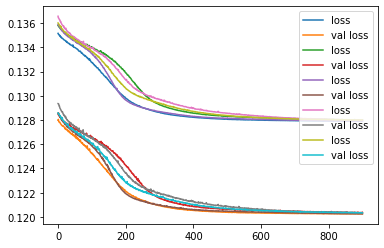

In [ ]:
for history in history_base:
  plt.plot(history.history['loss'][100:], label='loss')
  plt.plot(history.history['val_loss'][100:], label='val loss')
plt.legend()

0.12790195643901825 12.385457992553711
0.12800270318984985 14.157687187194824
0.12790924310684204 12.146100997924805
0.1279861330986023 13.26049518585205
0.127996027469635 13.443375587463379


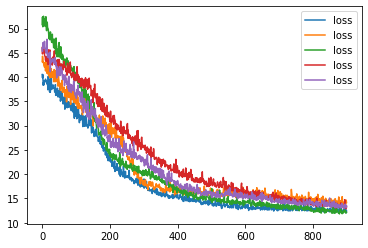

In [ ]:
for history in history_base:
  plt.plot(history.history['mape'][100:], label='loss')
  print(history.history['loss'][-1], history.history['mape'][-1])
plt.legend()

2/2 [==============================] - 0s 8ms/step
MSE mean:  4.244994386966492e-14    MSE max:  3.8691169531880163e-13
MAE mean:  1.258400734638174e-07    MAE max:  6.220222627195924e-07
MAPE:  7.175328680340473
R2:  0.9679374354742368


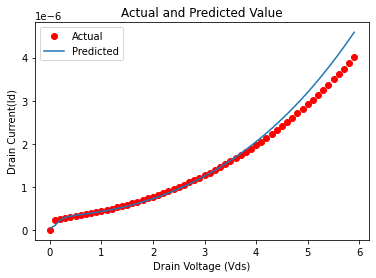

In [ ]:
plot_predict('mosfet_val_2.csv', model_base[2], process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)

2/2 [==============================] - 0s 3ms/step
MSE mean:  2.2425843506010686e-10    MSE max:  6.983288929497626e-10
MAE mean:  1.2422134695538464e-05    MAE max:  2.6425913285064767e-05
MAPE:  7.885585925908026
R2:  0.8555469048225073


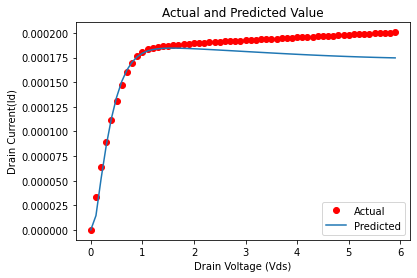

In [ ]:
plot_predict('mosfet_val_3.csv', model_base[2], process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
Xval, yval = data_lognorm.transform(df_val)
yval = data_lognorm.retransform_y(yval)

In [ ]:
y_pred = model_base[2].predict(Xval)
y_pred = data_lognorm.retransform_y(y_pred)

print_loss(yval, y_pred)

17403/17403 [==============================] - 24s 1ms/step
MSE mean:  3.825858553288807e-09    MSE max:  5.768362798460527e-07
MAE mean:  1.7304661501840618e-05    MAE max:  0.0007594973863326014
MAPE:  12.258822381255785
R2:  0.8533138884402125


In [ ]:
y_pred = model_base[0].predict(Xval)
for i in range(4):
  y_pred += model_base[i + 1].predict(Xval)

y_pred = y_pred / 5
# print(y_pred)

y_pred = data_lognorm.retransform_y(y_pred)

print_loss(yval, y_pred)

17403/17403 [==============================] - 24s 1ms/step
MSE mean:  3.969713723691839e-09    MSE max:  5.76839326380469e-07
MAE mean:  2.1302497964897568e-05    MAE max:  0.000759499391955299
MAPE:  17.56265682881504
R2:  0.8477983798869618


MSE mean:  3.8382027740354014e-09    MSE max:  5.76840051745192e-07

MAE mean:  1.7092565281146e-05    MAE max:  0.0007594998694833279

MAPE:  11.686421683962703

R2:  0.8528406023225129

In [ ]:
class ProcessDataGenerate(ProcessDataLog):
  """Действуем на данные функцией с LOG10 и нормализируем тестувую выборку"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    X = self.generate(X)

    self.scaler_X, self.scaler_Y, X, y = self._scaler(X, y)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def generate(self, X):
    T = X['T'] + 273.15
    X = np.c_[X['Vgs'], X['Vds'], X['Vgs']**2, X['Vds']**2, X['Vgs'] * X['Vds'],
              X['Vgs']**2 * X['Vds'], X['Vgs'] * X['Vds']**2,

              1 / X['L'], 
              X['Vgs'] / X['L'], X['Vds'] / X['L'], X['Vgs']**2 / X['L'], X['Vds']**2 / X['L'], X['Vgs'] * X['Vds'] / X['L'],
              # X['Vgs']**2 * X['Vds'] / X['L'], X['Vgs'] * X['Vds']**2 / X['L'],

              1 / X['W'], 
              X['Vgs'] * X['W'], X['Vds'] * X['W'], X['Vgs']**2 * X['W'], X['Vds']**2 * X['W'], X['Vgs'] * X['Vds'] * X['W'],
              # X['Vgs']**2 * X['Vds'] * X['W'], X['Vgs'] * X['Vds']**2 * X['W'],

              1 / T, T,
              # X['Vgs'] * T, X['Vds'] * T, X['Vgs']**2 * T, X['Vds']**2 * T, X['Vgs'] * X['Vds'] * T,
              # X['Vgs']**2 * X['Vds'] * T, X['Vgs'] * X['Vds']**2 * T,
              ]
    # X = np.c_[X, X['L']]
    # X = np.c_[X, 1 / X['L'], X['Vgs'] / X['L'], X['Vds'] / X['L']]
    # X = np.c_[X, 1 / X['W'], X['Vgs'] * X['W'], X['Vds'] * X['W']]
    # X = np.c_[X, 1 / X['T'], X['Vgs'] / X['T'], X['Vds'] / X['T']]
    return X


  def _scaler(self, X, y):
    scaler_X = preprocessing.StandardScaler().fit(X)
    X = scaler_X.transform(X)

    y = y.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    y = scaler_Y.transform(y)
    return scaler_X, scaler_Y, X, y


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    X = self.generate(X)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y_in):
    y = y_in.copy()
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return 10 ** (-1 / y)

In [ ]:
# class ProcessDataGenerate(object):
#   """Миксин создания модели подготовки данных"""
#   def __init__(self, df, test_size=0.2, random_state=42):

#     X, y = self._split_x_y(df)
#     X = self.generate(X)

#     X_train, X_test, y_train, y_test = self._split_train_test(
#         X, y, test_size=test_size, random_state=random_state
#         )
    
#     self.scaler_X, self.scaler_Y, X_train, y_train = self._scaler(X_train, y_train)

#     X_test, y_test = self.scaler_X.transform(X_test), self.scaler_Y.transform(y_test.reshape(-1, 1))
    
#     self.X_train = X_train
#     self.X_test = X_test
#     self.y_train = y_train
#     self.y_test = y_test


#   def _scaler(self, X, y):
#     scaler_X = preprocessing.StandardScaler().fit(X)
#     X = scaler_X.transform(X)

#     y = y.reshape(-1, 1)
#     scaler_Y = preprocessing.StandardScaler().fit(y)
#     y = scaler_Y.transform(y)
#     return scaler_X, scaler_Y, X, y

    


#   def generate(self, X):
#     T = X['T'] + 273.15
#     # X = np.c_[X, X['Vgs']**2, X['Vds']**2, X['Vgs'] * X['Vds'],
#     #           X['Vgs']**2 * X['Vds'], X['Vgs'] * X['Vds']**2,
#     #           1 / X['L'], X['Vds']/X['L'], X['Vgs']/X['L'], X['W']/X['L'],
#     #           1 / X['W'], X['Vgs'] * X['W'], X['Vds'] * X['W'],
#     #           T, 1 / T, X['Vds']/T, X['Vgs']/T,
#     #           X['W']/T, X['L']/T, X['W']/(T*X['L'])]

#     X = np.c_[X, X['Vgs']**2, X['Vds']**2, X['Vgs'] * X['Vds'],
#               X['Vgs']**2 * X['Vds'], X['Vgs'] * X['Vds']**2,
#               1 / X['L'], X['W']/X['L'], X['W'] ** 2,
#               1 / T, X['Vds']/T, X['Vgs']/T,
#               X['W']/T, X['W']/(T*X['L'])]

#     # X = np.c_[X, X['L']]
#     # X = np.c_[X, 1 / X['L'], X['Vgs'] / X['L'], X['Vds'] / X['L']]
#     # X = np.c_[X, 1 / X['W'], X['Vgs'] * X['W'], X['Vds'] * X['W']]
#     # X = np.c_[X, 1 / X['T'], X['Vgs'] / X['T'], X['Vds'] / X['T']]
#     return X


#   def _split_x_y(self, df):
#     """разделение df на X и Y"""
#     X = df.iloc[:,0:5]
#     y = np.ravel(df["Id"])
#     return X, y


#   def _split_train_test(self, X, y, test_size, random_state):
#     """разделение на train и test"""
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
#                                                         random_state=random_state)
#     return X_train, X_test, y_train, y_test


#   def transform(self, df):
#     """функция подготовки данных
#         return: X и y"""
#     X, y = self._split_x_y(df)
#     X = self.generate(X)
#     return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

#   def retransform_y(self, y_in):
#     """функция перевода,
#      полученного Y в нормальный вид"""
#     y = y_in.copy()
#     y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
#     return y

In [ ]:
df = pd.read_csv('mosfet_simple.csv')
data = ProcessDataGenerate(df)
print(data.X_train)

[[ 5.32275155e-01  4.08926518e-01 -2.83973145e-01 ...  1.90292983e-02
   1.25749588e+00 -1.22473671e+00]
 [ 6.30767139e-01  6.30767139e-01 -2.54868042e-01 ...  3.67990509e-01
  -1.18913003e+00  1.22475304e+00]
 [-5.46153398e-01  2.43781239e-01 -1.83366314e-01 ... -6.12343194e-02
  -6.83658503e-02 -1.63302580e-05]
 ...
 [ 4.74465593e-01  6.30767139e-01 -2.98071329e-01 ...  9.00184100e-02
   1.25749588e+00 -1.22473671e+00]
 [ 5.83987569e-01 -2.05947067e-01 -2.69490896e-01 ... -6.24645886e-02
  -1.18913003e+00  1.22475304e+00]
 [-2.05947067e-01 -2.05947067e-01 -2.98071329e-01 ...  5.69795240e-02
   1.25749588e+00 -1.22473671e+00]]


In [ ]:
model = tf.keras.Sequential()

model.add(keras.layers.Dense(len(data.generate(df)[0]), activation='tanh', input_shape=(len(data.generate(df)[0]),), kernel_regularizer=keras.regularizers.l2(1e-8)))
# model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(30, activation='tanh', kernel_regularizer=keras.regularizers.l2(1e-8)))
model.add(keras.layers.Dense(1, activation='tanh'))

model.compile(optimizer='adam', loss='mse', metrics=['mape'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 21)                462       
                                                                 
 dense_106 (Dense)           (None, 30)                660       
                                                                 
 dense_107 (Dense)           (None, 1)                 31        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t1 = time.perf_counter()

history = model.fit(data.X_train, data.y_train, 
                      epochs=1000, 
                      validation_data=(data.X_test, data.y_test),
                      batch_size=256,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
15/15 [==============================] - 1s 14ms/step - loss: 0.9091 - mape: 364.4304 - val_loss: 0.5572 - val_mape: 188.5230
Epoch 2/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.4918 - mape: 305.5689 - val_loss: 0.3297 - val_mape: 127.6670
Epoch 3/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.3076 - mape: 150.6407 - val_loss: 0.2320 - val_mape: 63.7204
Epoch 4/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.2351 - mape: 83.5259 - val_loss: 0.1912 - val_mape: 52.5193
Epoch 5/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.1935 - mape: 68.9980 - val_loss: 0.1674 - val_mape: 45.4872
Epoch 6/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.1702 - mape: 64.0604 - val_loss: 0.1535 - val_mape: 46.8539
Epoch 7/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.1586 - mape: 60.9033 - val_loss: 0.1462 - val_mape: 45.0657
Epoch 8/1000
15/15 [======================

In [ ]:
def create_model():
  model = tf.keras.Sequential()

  model.add(keras.layers.Dense(len(data.generate(df)[0]), activation='tanh', input_shape=(len(data.generate(df)[0]),), kernel_regularizer=keras.regularizers.l2(1e-8)))
  model.add(keras.layers.Dense(30, activation='tanh', kernel_regularizer=keras.regularizers.l2(1e-8)))
  model.add(keras.layers.Dense(1, activation='tanh'))

  model.compile(optimizer='adam', loss='mse', metrics=['mape'])
  return model

t1 = time.perf_counter()
history_new = []
model_new = []

df_val = pd.read_csv('data_val_in.csv')
Xval, yval = data.transform(df_val)
yval = data.retransform_y(yval)

for i in range(5):
  model_new.append(create_model())
  history_new.append(model_new[i].fit(data.X_train, data.y_train, 
                      epochs=1000, 
                      validation_data=(data.X_test, data.y_test),
                      batch_size=256,
                      shuffle=True,
                      verbose=0,
                      ))
  y_pred = model_new[i].predict(Xval)
  y_pred = data.retransform_y(y_pred)
  print_loss(yval, y_pred)

print('time taken to run:', (time.perf_counter()-t1) / 5)

17403/17403 [==============================] - 22s 1ms/step
MSE mean:  3.812675496980682e-09    MSE max:  5.768283008075858e-07
MAE mean:  1.6640397080303283e-05    MAE max:  0.0007594921334731425
MAPE:  11.962686604451672
R2:  0.8538193361041493
17403/17403 [==============================] - 22s 1ms/step
MSE mean:  3.845948817318098e-09    MSE max:  5.768292437863494e-07
MAE mean:  1.7444246080324382e-05    MAE max:  0.0007594927542684982
MAPE:  12.285033311173175
R2:  0.8525436135673652
17403/17403 [==============================] - 21s 1ms/step
MSE mean:  3.811016998846605e-09    MSE max:  5.768287360286032e-07
MAE mean:  1.6875167028634718e-05    MAE max:  0.0007594924199941717
MAPE:  11.687877022686116
R2:  0.8538829240907223
17403/17403 [==============================] - 23s 1ms/step
MSE mean:  3.8069313584199255e-09    MSE max:  5.76827720512764e-07
MAE mean:  1.6034075344709248e-05    MAE max:  0.0007594917514448488
MAPE:  10.461693481702744
R2:  0.8540395704222774
17403/17403 

dict_keys(['loss', 'mape', 'val_loss', 'val_mape'])


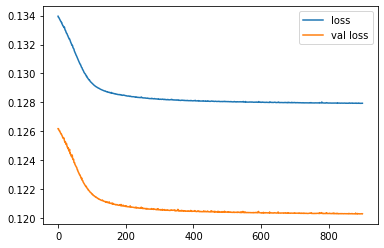

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'][100:], label='loss')
plt.plot(history.history['val_loss'][100:], label='val loss')
plt.legend()

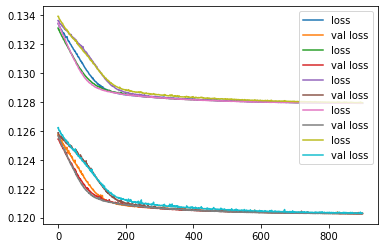

In [ ]:
for history in history_new:
  plt.plot(history.history['loss'][100:], label='loss')
  plt.plot(history.history['val_loss'][100:], label='val loss')
plt.legend()

0.12792445719242096 14.598065376281738
0.12792591750621796 13.175127029418945
0.12792189419269562 13.722119331359863
0.12790895998477936 12.741682052612305
0.12795011699199677 13.153528213500977


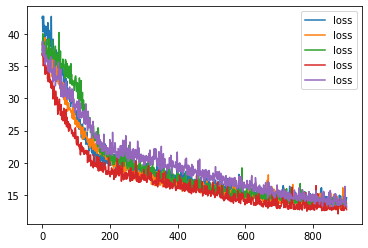

In [ ]:
for history in history_new:
  plt.plot(history.history['mape'][100:], label='loss')
  print(history.history['loss'][-1], history.history['mape'][-1])
plt.legend()

2/2 [==============================] - 0s 5ms/step
MSE mean:  6.588901848831897e-11    MSE max:  3.226785470979407e-10
MAE mean:  6.244857289893518e-06    MAE max:  1.7963255470485875e-05
MAPE:  4.2465251903320596
R2:  0.9575584630460223
2/2 [==============================] - 0s 4ms/step
MSE mean:  2.612043880934292e-10    MSE max:  1.2397635984803337e-09
MAE mean:  1.2605123776352705e-05    MAE max:  3.521027688730002e-05
MAPE:  7.470605739814453
R2:  0.8317486594253375


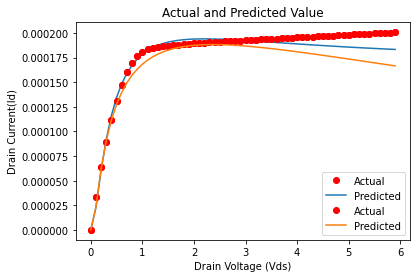

In [ ]:
plot_predict('mosfet_val_3.csv', model_new[3], process_data=data.transform, reprocess_data=data.retransform_y, end=-1)
plot_predict('mosfet_val_3.csv', model, process_data=data.transform, reprocess_data=data.retransform_y, end=-1)

2/2 [==============================] - 0s 5ms/step
MSE mean:  4.5256341799261855e-13    MSE max:  3.641083783638569e-12
MAE mean:  4.07208716810252e-07    MAE max:  1.9081624101838316e-06
MAPE:  17.88628247624597
R2:  0.6581775505772227
2/2 [==============================] - 0s 4ms/step
MSE mean:  5.528617041946343e-14    MSE max:  5.373947990203309e-13
MAE mean:  1.4904573810211639e-07    MAE max:  7.330721649471701e-07
MAPE:  8.683386743648684
R2:  0.95824219669409


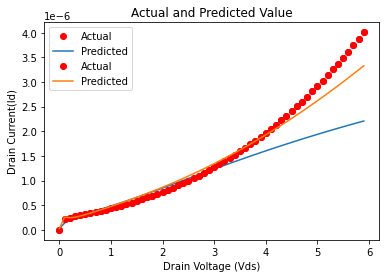

In [ ]:
plot_predict('mosfet_val_2.csv', model_new[3], process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_2.csv', model, process_data=data.transform, reprocess_data=data.retransform_y, end=-1)

3/3 [==============================] - 0s 3ms/step
MSE mean:  8.693059035252154e-10    MSE max:  3.3678862944039467e-09
MAE mean:  2.465400105109512e-05    MAE max:  5.803349286751528e-05
MAPE:  13.135233905738898
R2:  0.42520759531121033
3/3 [==============================] - 0s 3ms/step
MSE mean:  9.90334563567236e-10    MSE max:  2.7197352409328213e-09
MAE mean:  2.6783440704397825e-05    MAE max:  5.215108091816335e-05
MAPE:  14.878220186552591
R2:  0.3451824232058456


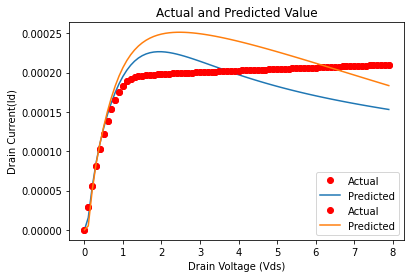

In [ ]:
plot_predict('mosfet_val_5.csv', model_new[3], process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_5.csv', model, process_data=data.transform, reprocess_data=data.retransform_y, end=-1)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
Xval, yval = data.transform(df_val)
yval = data.retransform_y(yval)

In [ ]:
y_pred = model.predict(Xval)
y_pred = data.retransform_y(y_pred)

print_loss(yval, y_pred)

17403/17403 [==============================] - 22s 1ms/step
MSE mean:  3.817160156586007e-09    MSE max:  5.768286634917733e-07
MAE mean:  1.683361440252262e-05    MAE max:  0.0007594923722406785
MAPE:  11.73671552114927
R2:  0.853647391096248


In [ ]:
y_pred = model_new[3].predict(Xval)
y_pred = data.retransform_y(y_pred)

print_loss(yval, y_pred)

17403/17403 [==============================] - 22s 1ms/step
MSE mean:  3.8069313584199255e-09    MSE max:  5.76827720512764e-07
MAE mean:  1.6034075344709248e-05    MAE max:  0.0007594917514448488
MAPE:  10.461693481702744
R2:  0.8540395704222774


In [ ]:
y_pred = model_new[0].predict(Xval)
for i in range(4):
  y_pred += model_new[i + 1].predict(Xval)

y_pred = y_pred / 5
# print(y_pred)

y_pred = data.retransform_y(y_pred)

print_loss(yval, y_pred)

17403/17403 [==============================] - 23s 1ms/step
MSE mean:  3.815687353565504e-09    MSE max:  5.768287360286032e-07
MAE mean:  1.6434992422643036e-05    MAE max:  0.0007594924199941717
MAPE:  11.046297496980582
R2:  0.8537038594013779


In [ ]:
# MSE mean:  3.841790221681768e-09    MSE max:  5.76838383405976e-07
# MAE mean:  1.779134621359705e-05    MAE max:  0.0007594987711681804
# MAPE:  13.276086495079538
# R2:  0.8527030570530421

In [ ]:
model.save('../model')